In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from google.colab import drive
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import glob
#drive.mount('/content/drive')

# Informações sobre o banco de dados

- Foi proposto que utilizasse o banco de dados do Activity Recognition system based on Multisensor data fusion (AReM) Data Set do UCI repository. 

- O link da onde foi obtido os dados: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+%28AReM%29

Este banco de dados contém medidas de sensores quando uma pessoa está fazendo um determinado exercício. Estes dados consiste na potência de um sinal que é recebida em intervalos de tempo regulares. Essa potência varia quando o usuário faz algum movimento.

Os sensores estão localizados no peito, perna esquerda e perna direita. 

Uma medida gravada no banco de dados consiste, por exemplo, no tempo x temos a média da potência dos sinais dos sensores que estão localizados nas duas pernas e a sua variância desta medida e sua variância. Logo temos as seguintes combinações de valores: 

- Média entre o sinal do sensor do peito e da perna direita (***nome da medida : avg_rss12***)
- Média entre o sinal do sensor do peito e da perna esquerda avg_rss13 (***nome da media:  avg_rss13***)
- Média entre o sinal do sensor da perna esquerda e perna direita (***nome da medida : avg_rss23***)
- Variância entre o sinal do sensor do peito e da perna direita (***nome da medida : var_rss12***)
- Variância entre o sinal do sensor do peito e da perna esquerda avg_rss13 (***nome da média:  var_rss13***)
- Variância entre o sinal do sensor da perna esquerda e perna direita (***nome da medida : var_rss23***)



- Os exercícios que são feitos?
 *   stading (ficar de pé).
 *   sitting (sentar)
 *   cycling (ciclismo)
 *   walking(caminhando)
 *   bending1 (Dobramento do tipo 1)
 *   bending2 (Dobramento do tipo 2)
 *   lying (repouso).   



Objetivo é classificar se a pessoa está fazendo algum dos exercícios mencionados utilizando os seguintes classificadores:
- Redes MLP.
- Redes RBF
- SVM não-linear com o kernel RBF.
Comparar qual deles é o melhor, entre os melhores configurações encontradas de cada classificador.


Neste notebook vai de análise exploratória dos dados até a modelagem da rede MLP e SVM.


# Juntar os dataframe

Como são vários arquivos scv, é proposto um algoritmo que junte todos arquivos em um único dataframe.

In [2]:
# Carrega todos arquivos scv que estão dentro de uma pasta e os armazena em uma lista 
def rot_aux(aux,aux1,ind,ind1):
    df_a   = pd.read_csv(aux1[ind1], skiprows=[0,1,2,3]) # carregar o dataframe que está dentro da pasta 
    rotulo = np.array(aux)[ind][29:len(aux[ind])] # rótulo do banco de dados carregado
    rot    = [] 
    for i in range(len(df_a)):
        rot.append(rotulo)
    df_a['Classes'] = rot # adcionar o rótulo na figura
    return df_a

In [3]:
# Concatena os arquivos que estão na lista que é obtida pela função rot_aux
def rotular_df(aux,ind): 
    a    = aux[ind] +'/*'
    aux1 = glob.glob(a) #listar as pastas que contém todos os dados de cada exercício
    df = pd.concat([rot_aux(aux,aux1,ind,ind1 = i) for i in range(len(aux1))],ignore_index=True)
    return df

In [4]:
aux  = glob.glob('/home/antoniojr/notebooks/AReM/*') #listar as pastas que contém todos os dados de cada exercício
df = pd.concat([rotular_df(aux,ind =i) for i in range(len(aux))],ignore_index=True) # dataframe que contém todos os parâmetros 

In [5]:
df=df.drop('# Columns: time', axis=1) # excluindo a coluna que não tenho interesse ((foi visto que os valores se repetem para cada classe) 

In [6]:
df.head() # olhando o banco de dados 

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Classes
0,48.0,0.0,6.25,0.43,2.00,0.71,M/lying
1,48.0,0.0,6.00,0.00,1.67,0.94,M/lying
2,48.0,0.0,6.00,0.00,2.00,1.00,M/lying
3,48.0,0.0,5.25,0.43,2.67,0.94,M/lying
4,48.0,0.0,5.50,0.50,2.00,0.82,M/lying


# Análise exploratória dos dados
As seguintes análises são propostas:
* Verificando se a dados faltantes. (ok)
* Análise estatística dos dados. Exemplo (ok):
  * Valor médio, mediana, desvio padrão, histogramas, matriz de correlação.

* Relação dos dados de target em relação aos demais dados.
* Verificando a quantidade de dados de cada classe. (ok)
* Criando label para cada classe dos dados de target (ok)
*Vendo se acurácia  na hora da classificação muda quando é retirado algum parâmetro.


### Dados faltantes

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42239 entries, 0 to 42238
Data columns (total 7 columns):
avg_rss12    42239 non-null float64
var_rss12    42239 non-null float64
avg_rss13    42239 non-null float64
var_rss13    42239 non-null float64
avg_rss23    42239 non-null float64
var_rss23    42239 non-null float64
Classes      42239 non-null object
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


### Análise estatistica dos dados

***Descrição dos dados***

In [8]:
df.describe()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,42239.000000,42239.000000,42239.000000,42239.000000,42239.000000,42239.000000
mean,38.917264,1.459145,14.278160,1.502241,16.035170,1.620705
std,6.337280,2.047973,5.435483,1.639519,6.736022,1.637070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.400000,11.330000,0.430000,12.000000,0.470000
50%,39.750000,0.500000,15.000000,0.830000,16.000000,1.000000
75%,43.750000,1.790000,18.000000,2.290000,19.250000,2.290000
max,56.250000,17.240000,35.000000,11.420000,40.330000,13.610000


***Histograma dos dados***

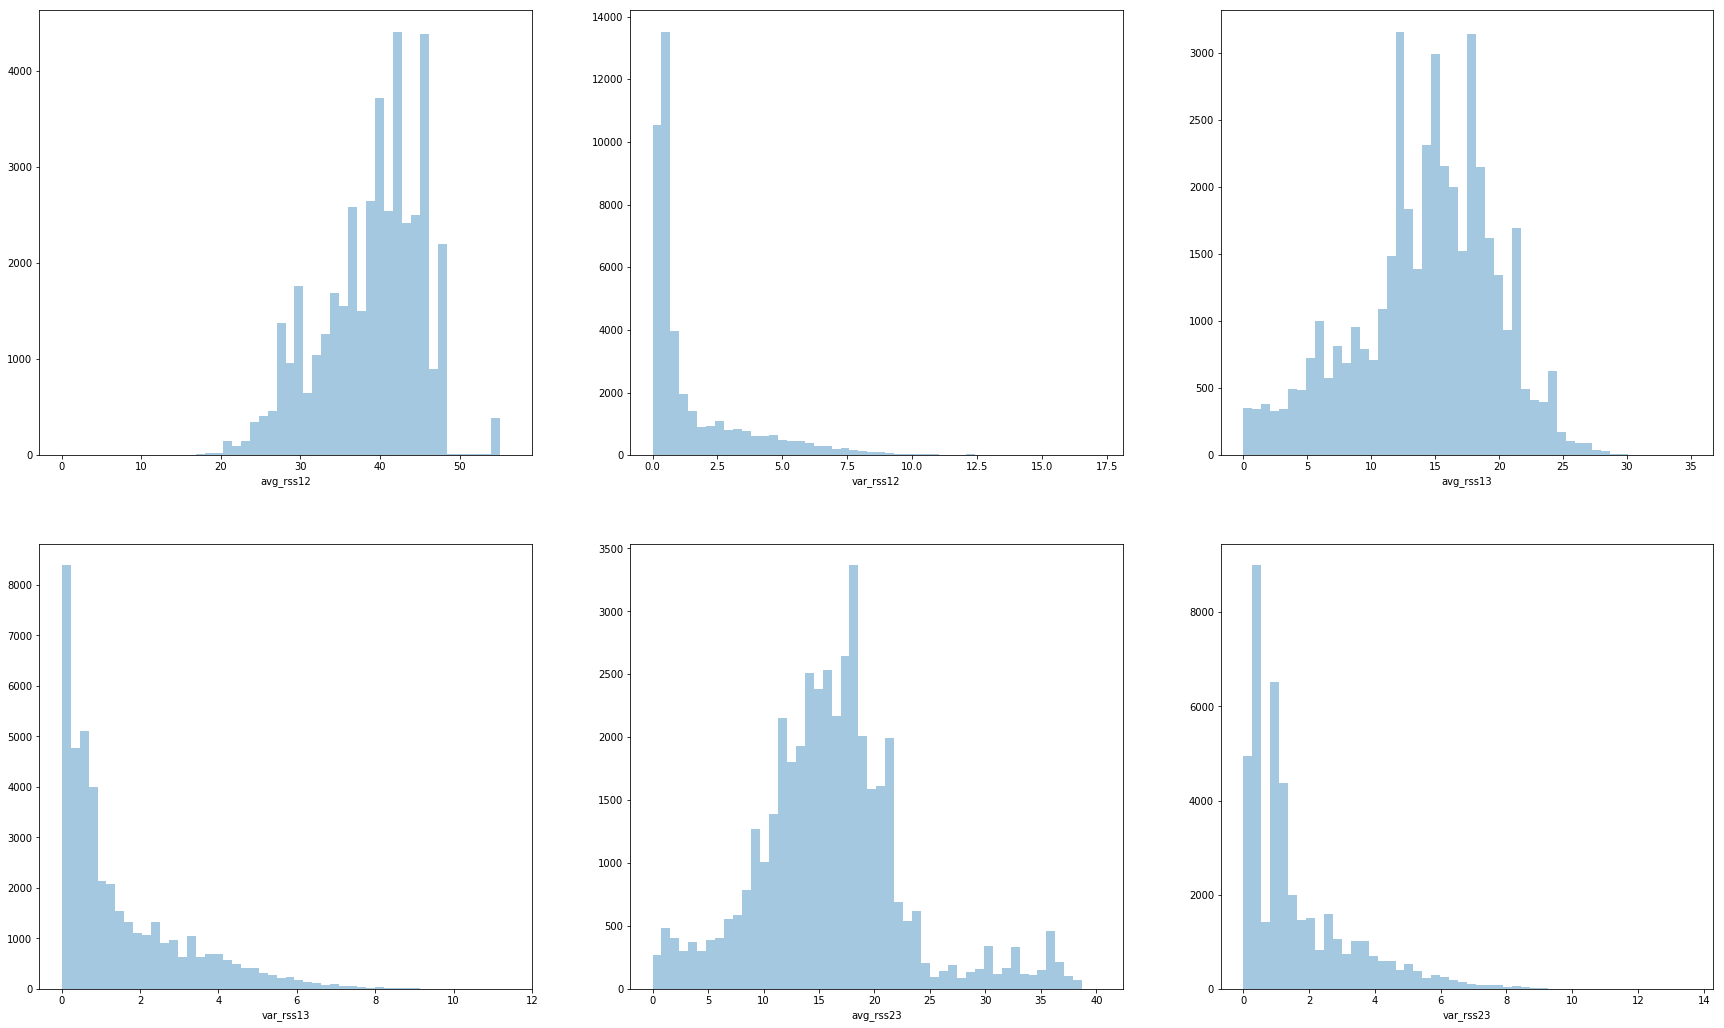

In [9]:

col = df.columns
fig = plt.figure(figsize=(30,18))
for i in range(1,7):    
    fig.add_subplot(2,3,i)
    sns.distplot(df[col[i-1]], kde=False) 

Pelos gráficos pode se observar que parâmetros "var_rss12" e "var_rss13" possuem um formato semelhante, porém ainda não é possível inferir se um deles pode ser descartado por conter um mesmo tipo de informação. 

***Matriz de correlação***

In [10]:
df.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
avg_rss12,1.0,-0.39,-0.033,-0.29,-0.0041,-0.29
var_rss12,-0.39,1.0,0.15,0.55,0.046,0.54
avg_rss13,-0.033,0.15,1.0,0.05,0.44,0.18
var_rss13,-0.29,0.55,0.05,1.0,0.079,0.53
avg_rss23,-0.0041,0.046,0.44,0.079,1.0,-0.055
var_rss23,-0.29,0.54,0.18,0.53,-0.055,1.0


Não existem variáveis com correlação forte entre si, logo não posso considerar pela informação da correlação que a mesma informação entre duas variáveis. 

### Relação dos dados de target com as outras variáveis 



In [11]:

df.groupby(['Classes'])[df.columns[:-1]].mean()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
Classes,,,,,,
M/bending1,42.667723,0.454360,19.158830,0.793399,30.201982,0.552390
M/bending2,29.415344,0.447622,15.326375,0.755219,18.728476,0.981906
M/cycling,36.747143,2.688332,16.396611,2.989278,17.398582,3.037336
M/lying,39.850217,0.343333,7.264876,0.580935,9.258135,0.660632
M/sitting,41.748485,0.401425,14.864027,0.750731,16.101104,0.902893
M/standing,43.857747,0.398604,14.773876,0.616150,13.704479,0.913015
M/walking,34.433676,4.337393,15.394560,3.203608,16.025058,3.343613


In [12]:
df.groupby(['Classes'])[df.columns[:-1]].std()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
Classes,,,,,,
M/bending1,2.361918,0.400185,4.553348,0.915341,5.761234,0.543230
M/bending2,5.654294,0.696356,6.575649,0.916931,5.899880,0.966435
M/cycling,3.821135,1.934536,3.606656,1.708521,3.302940,1.764949
M/lying,7.587485,0.376233,3.847125,0.668262,5.107438,0.575736
M/sitting,4.154320,0.420755,5.209214,0.867957,5.005339,0.846490
M/standing,2.626211,0.376943,3.984945,0.723276,3.908023,0.738799
M/walking,4.808603,2.443454,2.912519,1.624394,3.112483,1.701237


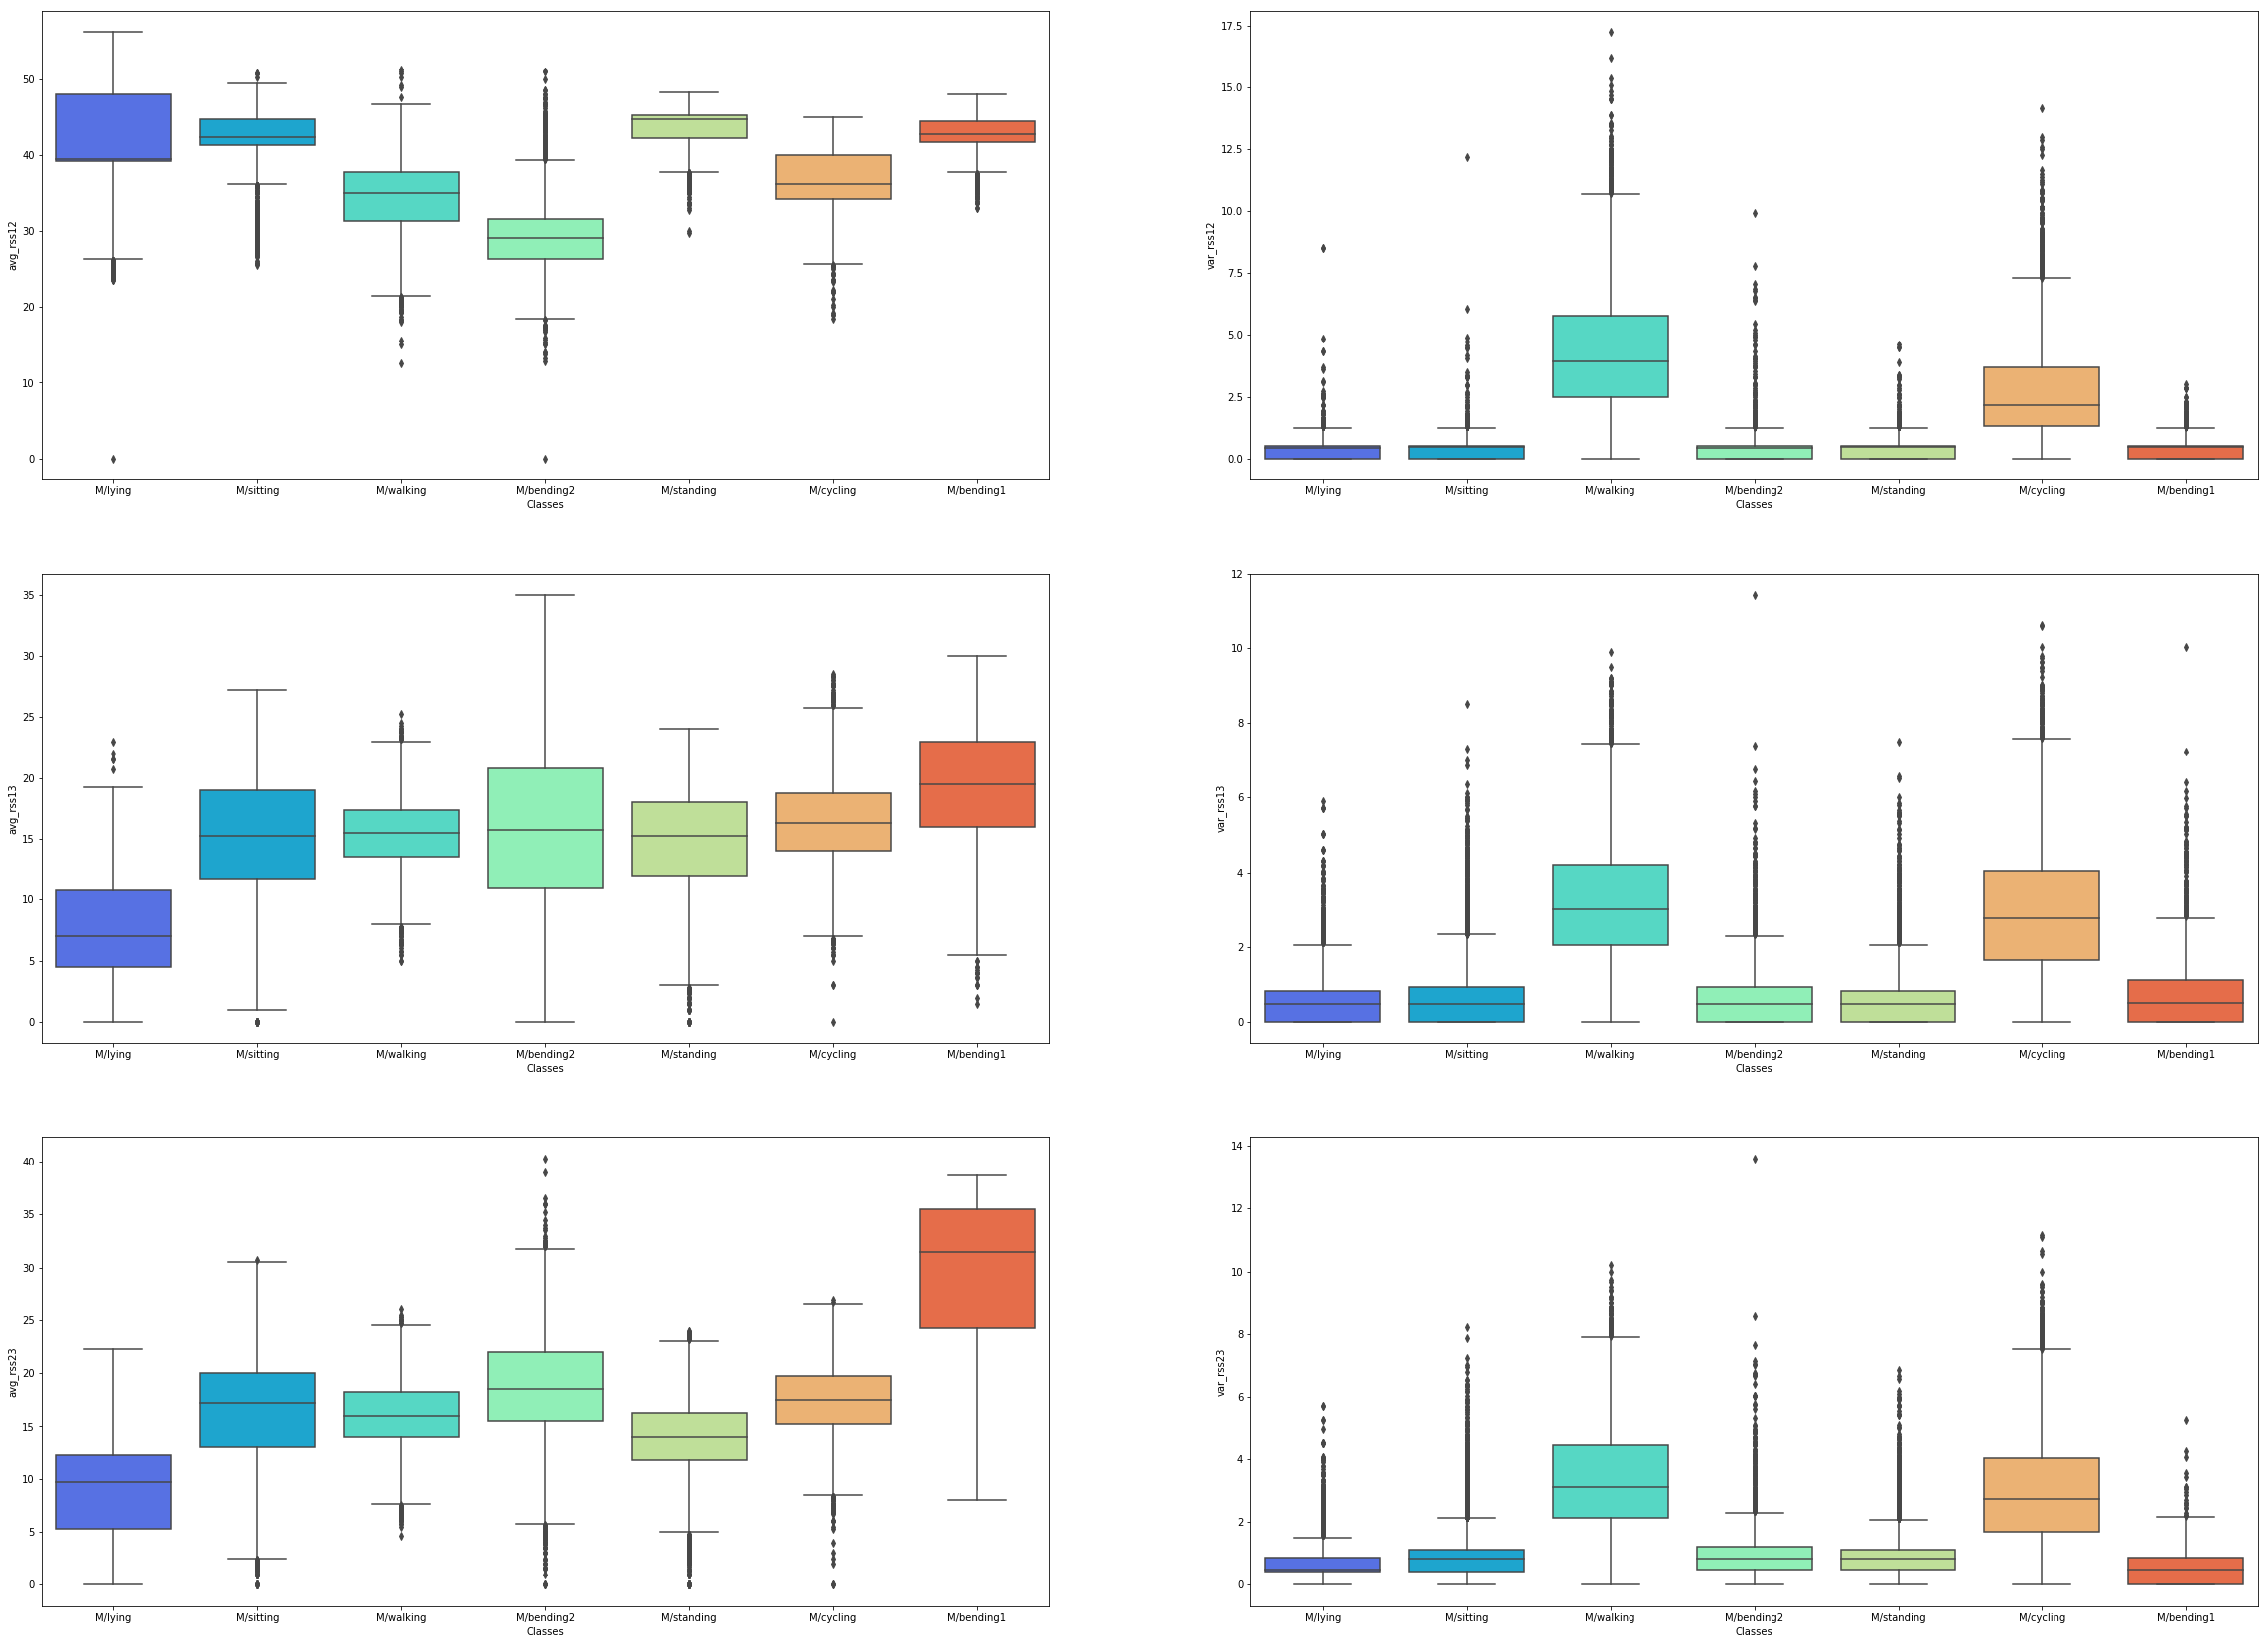

In [13]:
plt.figure(figsize=[40,40])
for i in range(len(df.columns)-1):
  plt.subplot(4,2,1 + i)
  sns.boxplot(x ='Classes',y =df.columns[i],data=df, palette='rainbow')

### quantidade de dados por classe

In [14]:
df['Classes'].value_counts()/max(df['Classes'].value_counts())

M/walking     1.000000
M/lying       1.000000
M/cycling     1.000000
M/standing    1.000000
M/sitting     0.999861
M/bending1    0.466667
M/bending2    0.400000
Name: Classes, dtype: float64

Mesmo tendo um desequilíbrio de classe no banco de dados, este fato não é um fator preocupante. Pois a classe com o menor número  de eventos possui em termos de contagem 40 % do tamanho da maior classe .

## Criando as label

In [15]:
y = []
for i in range(len(df['Classes'].unique())):
    cont1 = np.ones((np.sum(np.array(df['Classes'].unique()[i] == df['Classes'])),1))*[i]
    y.append(cont1)

In [16]:
df['Classes'] = np.concatenate(y)

In [17]:
df.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Classes
0,48.0,0.0,6.25,0.43,2.00,0.71,0.0
1,48.0,0.0,6.00,0.00,1.67,0.94,0.0
2,48.0,0.0,6.00,0.00,2.00,1.00,0.0
3,48.0,0.0,5.25,0.43,2.67,0.94,0.0
4,48.0,0.0,5.50,0.50,2.00,0.82,0.0


# Modelagem dos modelos

### Separando os dados de treinamento, teste.

In [18]:
from sklearn.model_selection import train_test_split 

In [19]:
X_train1, X_teste1, y_train1, y_teste1 = train_test_split(df[df.columns[0:-1]].values, np.ravel(df['Classes']), test_size=0.70, random_state=101) # dados do treinamento

Foi separado 70 % dos dados para treinamento, 30 % para teste.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Modelando a rede neural MLP

In [21]:
kf = KFold(n_splits=5) # selecionado 5 folds para realizar a validação cruzada

In [22]:
neurons      = range(1,155,5)
acerto_v1    = np.zeros((5,len(neurons)))
acerto_v2    = np.zeros((5,len(neurons)))
acerto_v3    = np.zeros((5,len(neurons)))
acerto_t     = np.zeros((5,len(neurons)))
scaler       = StandardScaler() 
j = 0
for linhas_treino, linhas_valid in kf.split(X_train1):
    
    X_t, X_v = X_train1[linhas_treino], X_train1[linhas_valid]
    y_t, y_v = y_train1[linhas_treino], y_train1[linhas_valid]
    # como todos os classificadores são baseados em distância, vou normalizar os dados 
    X_t     = scaler.fit_transform(X_t) # dados de treinamento normalizado
    X_v     = scaler.fit_transform(X_v) # dados de validação normalizado
    #y_t = y_t
    #y_v = y_v
    for i in range(len(neurons)):
        clf = MLPClassifier(hidden_layer_sizes=neurons[i], solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
        #clf.fit(X_t, y_t)
        #acerto_t[j][i]  = clf.score(X_t,y_t)
        clf.fit(X_t, y_t)
        
        y_pred = clf.predict(X_v)
        #accuracy_score(y_true, y_pred)
        acerto_v1[j][i]  = accuracy_score(y_v,y_pred)
        
        clf = MLPClassifier(hidden_layer_sizes=(neurons[i],neurons[i]), solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
        #clf.fit(X_t, y_t)
        #acerto_t[j][i]  = clf.score(X_t,y_t)
        clf.fit(X_t, y_t)        
        y_pred = clf.predict(X_v)
        #accuracy_score(y_true, y_pred)
        acerto_v2[j][i]  = accuracy_score(y_v,y_pred)
        
        clf = MLPClassifier(hidden_layer_sizes=(neurons[i],neurons[i],neurons[i]), solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
        clf.fit(X_t, y_t)        
        y_pred = clf.predict(X_v)
        #accuracy_score(y_true, y_pred)
        acerto_v3[j][i]  = accuracy_score(y_v,y_pred)
        
        
        
        
    j =  j + 1
    print(j)

1
2
3
4
5


(0, 0.8)

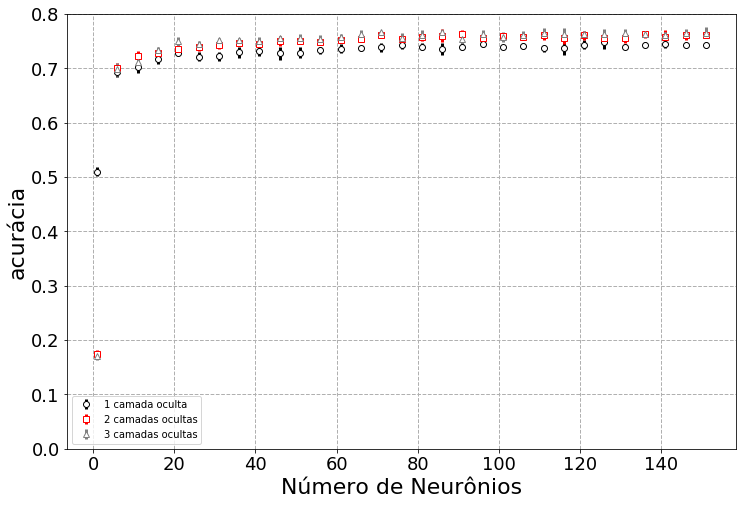

In [23]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.errorbar(range(1,155,5),np.mean(acerto_v1,axis= 0),np.std(acerto_v1,axis= 0),fmt ='o',color='black',ecolor='black', elinewidth=3,ls="none",mfc="w",label = '1 camada oculta')
plt.errorbar(range(1,155,5),np.mean(acerto_v2,axis= 0),np.std(acerto_v2,axis= 0),fmt ='s',color='red',ecolor='red', elinewidth=3,ls="none",mfc="w",label = '2 camadas ocultas')
plt.errorbar(range(1,155,5),np.mean(acerto_v3,axis= 0),np.std(acerto_v3,axis= 0),fmt ='^',color='gray',ecolor='gray', elinewidth=3,ls="none",mfc="w",label = '3 camadas ocultas')

plt.legend()
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
plt.xlabel('Número de Neurônios', size=22)
plt.ylim(0,0.8)


In [24]:
print('Melhor modelo usando apenas a média')
print('número de neurônios na camada oculta',range(1,155,5)[np.argmax(np.mean(acerto_v3,axis= 0))])

Melhor modelo usando apenas a média
número de neurônios na camada oculta 86


In [25]:
print('Valor', 'std')
print('Acurácia',np.max(np.mean(acerto_v3,axis= 0)),'std',np.std(acerto_v3,axis= 0)[np.argmax(np.mean(acerto_v3,axis= 0))])

Valor std
Acurácia 0.7661588277142889 std 0.003471496894505829


In [26]:
print('Melhor modelo usando a média e seu desvio padrão')
print('Valor', 'std')
print('Acurácia',np.mean(acerto_v3,axis= 0)[-1],'std',np.std(acerto_v3,axis= 0)[-1])
print('Número de neurônios 51')
print('O modelo tem 3 camadas ocultas')

Melhor modelo usando a média e seu desvio padrão
Valor std
Acurácia 0.7656847388339102 std 0.009547637228188374
Número de neurônios 51
O modelo tem 3 camadas ocultas


# Modelando o SVM

In [27]:
from sklearn import svm  # inportar instancia que tem o SVM

In [28]:
C = np.array([1,10,100]) # parâmetro C
gm =  np.linspace(0.01,1,10) # parâmetro gamma
er_test_svm = np.zeros((len(C),len(gm),5))
er_val_svm  = np.zeros((len(C),len(gm),5))

k = 0
for linhas_treino, linhas_valid in kf.split(X_train1):
    
    X_t, X_v = X_train1[linhas_treino], X_train1[linhas_valid]
    y_t, y_v = y_train1[linhas_treino], y_train1[linhas_valid]
    # como todos os classificadores são baseados em distância, vou normalizar os dados 
    X_t     = scaler.fit_transform(X_t) # dados de treinamento normalizado
    X_v     = scaler.fit_transform(X_v) # dados de validação normalizado

    for i in range(len(C)):
        for j in range(len(gm)):
            model = svm.SVC(C[i],kernel = 'rbf', gamma = gm[j])  # modelo 
            #model.fit(X_train1,y_train1)                         # treinando o modelo
            #er_test_svm[i][j][k] = model.score(X_t,y_t) # trainamento
            #er_val_svm[i][j][k]  = model.score(X_v,y_v) # validação
            #print(clf.score(X_val,y_val))
            
            model.fit(X_t, y_t)        
            y_pred = model.predict(X_v)
            er_val_svm[i][j][k]  = accuracy_score(y_v,y_pred)
            
            
    k =  k + 1
    print(k)

1
2
3
4
5


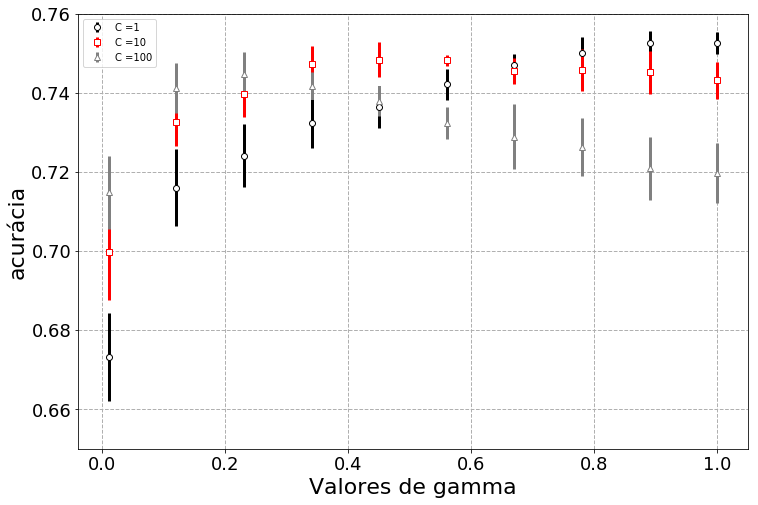

In [29]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.errorbar(gm,np.mean(er_val_svm[0],axis= 1),np.std(er_val_svm[0],axis= 1),fmt ='o',color='black',ecolor='black', elinewidth=3,ls="none",mfc="w",label = 'C =1')
plt.errorbar(gm,np.mean(er_val_svm[1],axis= 1),np.std(er_val_svm[1],axis= 1),fmt ='s',color='red',ecolor='red', elinewidth=3,ls="none",mfc="w",label = 'C =10')
plt.errorbar(gm,np.mean(er_val_svm[2],axis= 1),np.std(er_val_svm[2],axis= 1),fmt ='^',color='gray',ecolor='gray', elinewidth=3,ls="none",mfc="w",label = 'C =100')

plt.legend()
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
plt.xlabel('Valores de gamma', size=22)
plt.ylim(0.65,0.76)
plt.show()

Claramente o melhor configuração do SVM encontrado é de C = 1 e gamma = 1

In [30]:
print('Acurácia',np.mean(er_val_svm[0],axis= 1)[9],'Desvio padrão',np.std(er_val_svm[0],axis= 1)[-1])

Acurácia 0.7526638427445906 Desvio padrão 0.002677892504299311


# Seleção de variáveis, por modelo.
### MLP

In [31]:
acerto_v = np.zeros((5,X_t.shape[1]))
j =0

In [32]:
for linhas_treino, linhas_valid in kf.split(X_train1):
    
    X_t, X_v = X_train1[linhas_treino], X_train1[linhas_valid]
    y_t, y_v = y_train1[linhas_treino], y_train1[linhas_valid]
    #  como todos os classificadores são baseados em distância, vou normalizar os dados 
    X_t     = scaler.fit_transform(X_t) # dados de treinamento normalizado
    X_v     = scaler.fit_transform(X_v) # dados de validação normalizado

    for i in range(X_t.shape[1]):
        clf = MLPClassifier(hidden_layer_sizes=(86,86,86), solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
        clf.fit(X_t[:,np.delete(np.arange(X_t.shape[1]),i)], y_t)
        y_pred = clf.predict(X_v[:,np.delete(np.arange(X_t.shape[1]),i)])
        acerto_v[j][i] = accuracy_score(y_v,y_pred)
    
    j =  j + 1
    print(j)      

1
2
3
4
5


In [33]:
acerto_vm = np.mean(acerto_v, axis =0)
acerto_vs = np.std(acerto_v, axis =0)

In [34]:
acerto_V = np.zeros(X_t.shape[1]+1)
at = np.mean(acerto_v3,axis = 0)
acerto_V[0] = at[np.argmax(at)]
acerto_V[1:] = acerto_vm


acerto_S = np.zeros(X_t.shape[1]+1)
at = np.std(acerto_v3,axis = 0)
acerto_S[0] = at[np.argmax(at)]
acerto_S[1:] = acerto_vs

In [35]:
x = ['Todos','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
       'var_rss23', 'Classes']

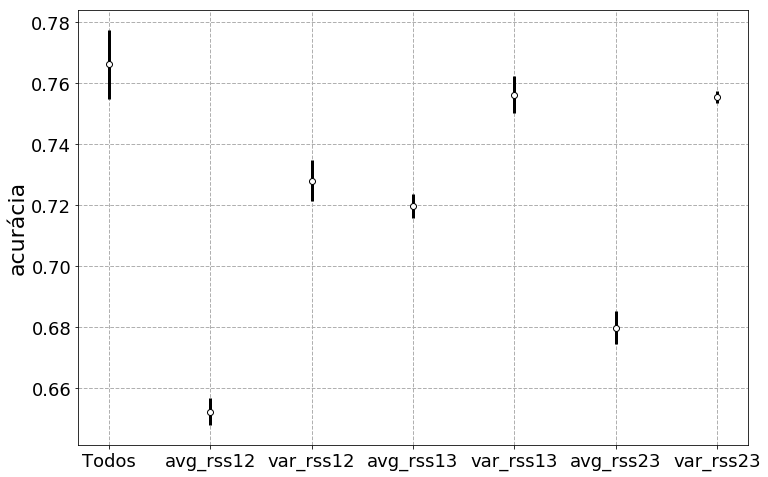

In [36]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.errorbar(np.arange(X_t.shape[1]+1),acerto_V,acerto_S,fmt ='o',color='black',ecolor='black', elinewidth=3,ls="none",mfc="w",label = 'C =1')
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
ax = plt.gca()
ax.set_xticks(np.arange(X_t.shape[1]+1))
ax.set_xticklabels(x)
plt.show()

pelo comportamento do gráfico nenhuma destas variáveis podem ser descartadas para este modelos 

In [37]:
act_v = np.zeros((5,X_t.shape[1]))
j =0

In [38]:
for linhas_treino, linhas_valid in kf.split(X_train1):
    
    X_t, X_v = X_train1[linhas_treino], X_train1[linhas_valid]
    y_t, y_v = y_train1[linhas_treino], y_train1[linhas_valid]
    #  como todos os classificadores são baseados em distancia, vou normaliza os dados
    X_t     = scaler.fit_transform(X_t) # dados de treinamento normalizado
    X_v     = scaler.fit_transform(X_v) # dados de validação normalizado

    for i in range(X_t.shape[1]):
        model = svm.SVC(1,kernel = 'rbf', gamma = 1)  # modelo 
        model.fit(X_t[:,np.delete(np.arange(X_t.shape[1]),i)], y_t)
        y_pred = model.predict(X_v[:,np.delete(np.arange(X_t.shape[1]),i)])
        act_v[j][i] = accuracy_score(y_v,y_pred)
    
    j =  j + 1
    print(j)      

1
2
3
4
5


In [39]:
acerto_vm = np.mean(act_v, axis =0)
acerto_vs = np.std(act_v, axis =0)

In [40]:
acerto_V = np.zeros(X_t.shape[1]+1)
at = np.mean(er_val_svm[0],axis = 1)
acerto_V[0] = at[np.argmax(at)]
acerto_V[1:] = acerto_vm


acerto_S = np.zeros(X_t.shape[1]+1)
at = np.std(er_val_svm[0],axis = 1)
acerto_S[0] = at[np.argmax(at)]
acerto_S[1:] = acerto_vs

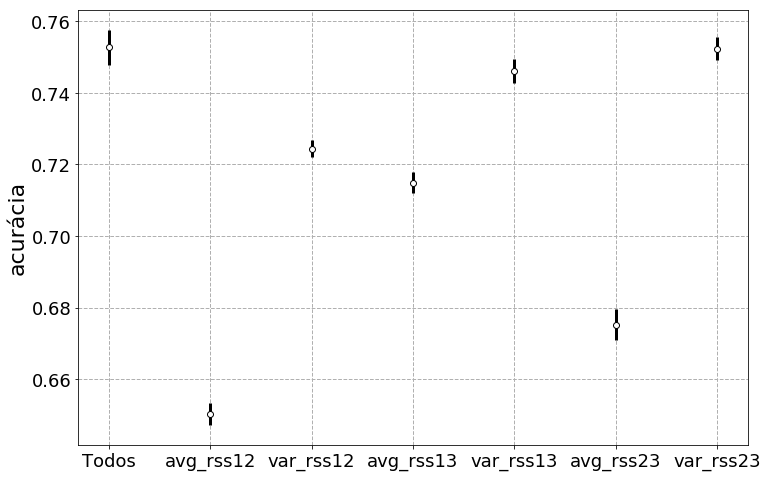

In [41]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.errorbar(np.arange(X_t.shape[1]+1),acerto_V,acerto_S/np.sqrt(5),fmt ='o',color='black',ecolor='black', elinewidth=3,ls="none",mfc="w",label = 'C =1')
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
ax = plt.gca()
ax.set_xticks(np.arange(X_t.shape[1]+1))
ax.set_xticklabels(x)
plt.show()

Pelo comportamento do gráfico nenhuma variável vai ser descartada neste modelo.

### Obs: Na parte 1 deste trabalho teve a parte de pré-processamento de dados, análise exploratória dos dados. Também temos a parte da modelagem dos classificadores MLP e SVM, no qual o melhor modelo encontrado  para a MLP foi 3 camadas ocultas e 86 neurônios em cada uma delas, no caso do SVM foi com um c e gamma de 1.

### Na parte 2 teremos a modelagem da rede com kernel RBF.

### A última parte contém avaliação dos modelos, e mostra qual delas é melhor. 

